In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from rasterstats import zonal_stats
import rasterio
import matplotlib.pyplot as plt
import exactextract as ee  # Python wrapper for exactextract



# Data Preperation

In [2]:
#Load pre-existing park data
parks_gdf = gpd.read_file('Data/Riyadh_parks_stats_2024.geojson')
print("Loaded parks_gdf with columns:", parks_gdf.columns) 

Loaded parks_gdf with columns: Index(['osm_id', 'OBJECTID', 'FEATURE_ANAME', 'MUNICIPALITY', 'DISTRICT',
       'WALKING_TRACK', 'GREEN_AREAS', 'LAYERID', 'LAYERANAME', 'Validation',
       'area_m2', 'perimeter_m', 'LSI', 'ndvi_mean', 'vegetation_prop',
       'bare_sparse_prop', 'impervious_prop', 'park_id', 'geometry'],
      dtype='object')


In [3]:
# Define LST file path
lst_2024_path = 'Data/Raster/Riyadh_LST_EPSG20438_2024.tif' 

In [4]:
# Open LST raster to access pixel values and transformation parameters.
with rasterio.open(lst_2024_path) as lst_src:
    lst_transform = lst_src.transform
    lst_crs = lst_src.crs
    lst_data = lst_src.read(1)
#    print(np.nanmin(lst_data), np.nanmax(lst_data))

## 1. Buffer Creation

For each park, createt buffers at 30m intervals up to 300m for the comparison of LST across different zones, providing insights into the urban heat island effect and park cooling influence. ([Cai et al., 2023](https://www.researchgate.net/publication/374556563_Cooling_island_effect_in_urban_parks_from_the_perspective_of_internal_park_landscape); [Zhang et al., 2024](https://www.nature.com/articles/s41598-024-67277-2))


In [5]:
# 2. Generate Buffers (30m intervals up to 300m)
buffer_distances = range(30, 301, 30)  # [30, 60, 90,..., 300]

# Initialize GeoDataFrame with proper CRS
buffer_gdf = gpd.GeoDataFrame(columns=['park_id', 'distance', 'geometry'], crs=parks_gdf.crs)

for park_id, park in parks_gdf.iterrows():
    for dist in buffer_distances:
        # Create donut-shaped buffers (outer - inner)
        outer = park.geometry.buffer(dist)
        inner = park.geometry.buffer(max(0, dist-30))  # Handle 0-30m case
        ring = outer.difference(inner)
        
        # Append to GeoDataFrame
        buffer_gdf = pd.concat([
            buffer_gdf,
            gpd.GeoDataFrame({
                'park_id': [park_id],
                'distance': [dist],
                'geometry': [ring]
            }, crs=parks_gdf.crs)
        ], ignore_index=True)


In [6]:
# Verify the output structure
print(f"Generated {len(buffer_gdf)} buffer rings")
print("GeoDataFrame columns:", buffer_gdf.columns)
print("CRS:", buffer_gdf.crs)
print("Sample data:")
print(buffer_gdf.head(3))

Generated 2210 buffer rings
GeoDataFrame columns: Index(['park_id', 'distance', 'geometry'], dtype='object')
CRS: EPSG:20438
Sample data:
  park_id distance                                           geometry
0       0       30  POLYGON ((678371.261 2735243.793, 678368.638 2...
1       0       60  POLYGON ((678387.297 2735218.438, 678382.05 27...
2       0       90  POLYGON ((678403.333 2735193.084, 678395.463 2...


In [7]:
# Save to GeoJSON
# buffer_gdf.to_file('Data/Riyadh_parks_buffers-2.geojson', driver='GeoJSON')
# print("Saved buffers to GeoJSON")

## 2. LST Calculation

In [8]:
# Initialize buffer columns
for dist in range(30, 301, 30):
    parks_gdf[f'lst_buffer_{dist}m'] = np.nan

with rasterio.open(lst_2024_path) as src:
    # Get raster properties
    raster_nodata = src.nodata if src.nodata is not None else -999
    
    # 1. Process park interiors (area-weighted)
    park_stats = zonal_stats(
        parks_gdf,
        lst_2024_path,
        stats=['mean', 'count'],  # Add count to track pixels
        nodata=raster_nodata,
        all_touched=True,
        fractional=True,  # Key parameter for area weighting
        min_area_fraction=0.5,
        geojson_out=False
    )
    parks_gdf['lst_park'] = [x['mean'] for x in park_stats]
    parks_gdf['park_pixel_count'] = [x['count'] for x in park_stats if x['count'] is not None]  # Track pixel count

    # 2. Process buffer zones
    buffer_stats = zonal_stats(
        buffer_gdf,
        lst_2024_path,
        stats=['mean', 'count'],  # Add count to track pixels
        nodata=raster_nodata,
        all_touched=True,
        fractional=True,  # Key parameter for area weighting
        min_area_fraction=0.5,
        geojson_out=False
    )
    buffer_gdf['lst_mean'] = [x['mean'] for x in buffer_stats]
    buffer_gdf['pixel_count'] = [x['count'] for x in buffer_stats if x['count'] is not None]  # Track pixel count

    # 3. Populate results to parks dataframe
    for park_id in parks_gdf.index:
        park_buffers = buffer_gdf[buffer_gdf['park_id'] == park_id]
        
        for _, buffer in park_buffers.iterrows():
            dist = buffer['distance']
            lst_value = buffer['lst_mean']
            
            if lst_value is not None and not np.isnan(lst_value):
                parks_gdf.at[park_id, f'lst_buffer_{dist}m'] = lst_value

# Calculate cooling effects

print("Processing complete. Results include:")
print(f"- {len(parks_gdf)} parks processed")
print(f"- Cooling effects calculated for buffers 30-300m")

Processing complete. Results include:
- 221 parks processed
- Cooling effects calculated for buffers 30-300m


In [9]:
print(f"- Number of parks with valid lst_park: {parks_gdf['lst_park'].notna().sum()} ({parks_gdf['park_pixel_count'].sum()} pixels)")
print(f"- Number of buffers with valid lst_mean: {buffer_gdf['lst_mean'].notna().sum()} ({buffer_gdf['pixel_count'].sum()} pixels)")

- Number of parks with valid lst_park: 221 (5548 pixels)
- Number of buffers with valid lst_mean: 2210 (225933 pixels)


In [10]:
# Calculate cooling effects (ΔT between buffers and park interior)
for dist in range(30, 301, 30):
    parks_gdf[f'cooling_diff_{dist}m'] = (
        parks_gdf[f'lst_buffer_{dist}m'] - parks_gdf['lst_park']
    )

In [11]:
# Comment out export, only needed once:
parks_gdf.to_file('Data/Riyadh_parks_with_LST_Overlap.geojson', driver='GeoJSON')


## 3. Results Exploration

In [12]:
parks_gdf.head(4)

,osm_id,OBJECTID,FEATURE_ANAME,MUNICIPALITY,DISTRICT,WALKING_TRACK,GREEN_AREAS,LAYERID,LAYERANAME,Validation,...,cooling_diff_30m,cooling_diff_60m,cooling_diff_90m,cooling_diff_120m,cooling_diff_150m,cooling_diff_180m,cooling_diff_210m,cooling_diff_240m,cooling_diff_270m,cooling_diff_300m
0,55489671,1,حديقة الروضة العامة,07,102,√,√,2,الحدائق,None,...,0.179666,0.398891,0.493965,0.574302,0.652487,0.734173,0.845199,0.943977,0.974286,1.014341
1,675324223,4,حديقة الوفاء,07,102,√,√,2,الحدائق,None,...,0.043557,-0.017365,-0.026496,-0.070428,-0.060709,-0.041077,-0.021942,-0.028414,-0.053652,0.033966
2,690348908,5,حديقة النور,07,102,√,√,2,الحدائق,None,...,0.106120,0.316539,0.550310,0.724234,0.896672,1.023118,1.194337,1.372689,1.485476,1.519120
3,588810436,8,حديقة الماسة,07,098,√,√,2,الحدائق,None,...,-0.232920,-0.442030,-0.603462,-0.708823,-0.729700,-0.600355,-0.429867,-0.237166,-0.163357,-0.127953


In [13]:
parks_gdf.columns

Index(['osm_id', 'OBJECTID', 'FEATURE_ANAME', 'MUNICIPALITY', 'DISTRICT',
       'WALKING_TRACK', 'GREEN_AREAS', 'LAYERID', 'LAYERANAME', 'Validation',
       'area_m2', 'perimeter_m', 'LSI', 'ndvi_mean', 'vegetation_prop',
       'bare_sparse_prop', 'impervious_prop', 'park_id', 'geometry',
       'lst_buffer_30m', 'lst_buffer_60m', 'lst_buffer_90m', 'lst_buffer_120m',
       'lst_buffer_150m', 'lst_buffer_180m', 'lst_buffer_210m',
       'lst_buffer_240m', 'lst_buffer_270m', 'lst_buffer_300m', 'lst_park',
       'park_pixel_count', 'cooling_diff_30m', 'cooling_diff_60m',
       'cooling_diff_90m', 'cooling_diff_120m', 'cooling_diff_150m',
       'cooling_diff_180m', 'cooling_diff_210m', 'cooling_diff_240m',
       'cooling_diff_270m', 'cooling_diff_300m'],
      dtype='object')

In [14]:
parks_gdf['max_cooling'] = parks_gdf[[f'cooling_diff_{d}m' for d in range(30, 301, 30)]].min(axis=1)

parks_gdf['cooling_radius'] = (
    parks_gdf[[f'cooling_diff_{d}m' for d in range(30, 301, 30)]]
    .idxmin(axis=1)
    .str.extract(r'(\d+)')
    .astype(int)
)
# Verify results
print(parks_gdf[['park_id', 'lst_park', 'max_cooling', 'cooling_radius']].head())

   park_id   lst_park  max_cooling  cooling_radius
0        1  49.865155     0.179666              30
1        2  50.255625    -0.070428             120
2        3  49.876300     0.106120              30
3        4  51.361095    -0.729700             150
4        5  49.951662     0.075140              30


In [15]:
# Summary
avg_max_cooling = parks_gdf['max_cooling'].mean()
cooling_park_count = len(parks_gdf[parks_gdf['max_cooling'] < 0])
heat_island_count = len(parks_gdf[parks_gdf['max_cooling'] > 0])
avg_radius = parks_gdf['cooling_radius'].mean()

print(f"""
All praks summary:
1. Average maximum cooling effect: {avg_max_cooling:.1f}°C
2. {cooling_park_count} parks ({cooling_park_count/len(parks_gdf):.0%}) provide cooling
3. {heat_island_count} parks ({heat_island_count/len(parks_gdf):.0%}) act as heat islands  
4. Average cooling radius: {avg_radius:.0f}m
""")


All praks summary:
1. Average maximum cooling effect: -0.0°C
2. 98 parks (44%) provide cooling
3. 123 parks (56%) act as heat islands  
4. Average cooling radius: 108m



In [16]:
# Summary statistics for cooling differences
cooling_diff_stats = pd.DataFrame({
    'min': [parks_gdf[f'cooling_diff_{d}m'].min() for d in range(30, 301, 30)],
    'max': [parks_gdf[f'cooling_diff_{d}m'].max() for d in range(30, 301, 30)],
    'mean': [parks_gdf[f'cooling_diff_{d}m'].mean() for d in range(30, 301, 30)],
    'std': [parks_gdf[f'cooling_diff_{d}m'].std() for d in range(30, 301, 30)]
}, index=[f'{d}m' for d in range(30, 301, 30)])
print("\nSummary Statistics for Cooling Differences:")
print(cooling_diff_stats)


Summary Statistics for Cooling Differences:
           min       max      mean       std
30m  -0.232920  3.703679  0.138124  0.362567
60m  -0.442030  4.909189  0.237900  0.518688
90m  -0.616207  5.761034  0.316773  0.645207
120m -0.984665  6.275205  0.369527  0.738305
150m -1.356484  6.511381  0.409504  0.799941
180m -1.615560  6.541607  0.438557  0.839227
210m -1.761129  6.569215  0.468460  0.864924
240m -1.856248  6.531751  0.494048  0.879269
270m -1.866985  6.576217  0.512221  0.895262
300m -1.798109  6.535385  0.528853  0.903641


The above results show varying cooling/heating impact

In [17]:
# Get top 5 cooling parks
top_coolers = parks_gdf.nsmallest(5, 'max_cooling')[['park_id', 'max_cooling', 'cooling_radius', 'area_m2', 'ndvi_mean']]

print("\nTop Cooling Parks:")
print(top_coolers.to_markdown(index=False))

# Calculate their common traits
avg_top_ndvi = top_coolers['ndvi_mean'].mean()
avg_top_area = top_coolers['area_m2'].mean()

print(f"\nCommon Traits:\n- Average NDVI: {avg_top_ndvi:.2f}\n- Average Area: {avg_top_area:,.0f} m²")


Top Cooling Parks:
|   park_id |   max_cooling |   cooling_radius |   area_m2 |   ndvi_mean |
|----------:|--------------:|-----------------:|----------:|------------:|
|       218 |      -1.86698 |              270 |   4510.73 |        0.13 |
|       207 |      -1.17839 |              300 |   5020.02 |        0.15 |
|        79 |      -1.15391 |              210 |   1144.85 |        0.11 |
|        95 |      -1.0178  |              210 |   3263.09 |        0.13 |
|        45 |      -1.0168  |              300 |   6050.12 |        0.17 |

Common Traits:
- Average NDVI: 0.14
- Average Area: 3,998 m²


In [18]:
# Analyze worst heat islands
heat_islands = parks_gdf.nlargest(5, 'max_cooling')[[ 'max_cooling', 'impervious_prop', 'area_m2']]

print("\nWorst Heat Islands:")
print(heat_islands.to_markdown(index=False))

# Calculate their characteristics
avg_heat_paved = heat_islands['impervious_prop'].mean()
avg_heat_size = heat_islands['area_m2'].mean()

print(f"\nCommon Issues:\n- Average paved surface: {avg_heat_paved:.0%}\n- Average size: {avg_heat_size:,.0f} m²")


Worst Heat Islands:
|   max_cooling |   impervious_prop |   area_m2 |
|--------------:|------------------:|----------:|
|      3.70368  |              0.11 |  236313   |
|      2.00947  |              0.12 |  258130   |
|      1.66351  |              0.22 |  130298   |
|      1.41541  |              0.08 |   41188.9 |
|      0.863854 |              0.84 |  129732   |

Common Issues:
- Average paved surface: 27%
- Average size: 159,132 m²


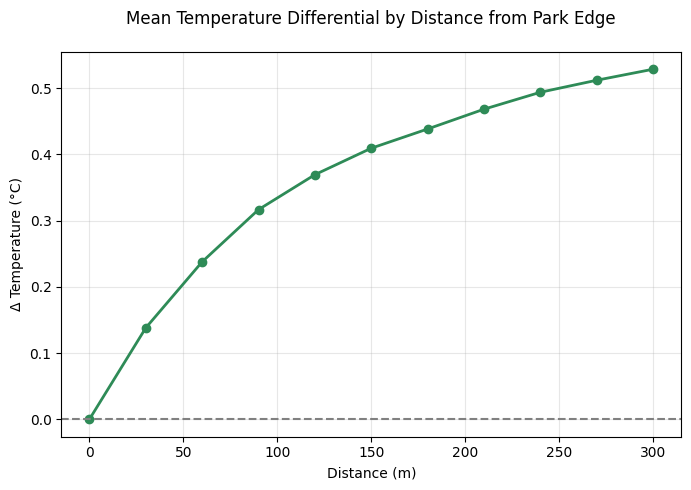

In [19]:
# Calculate mean cooling at each distance
distances = [0] + list(range(30, 301, 30))
mean_cooling = [0] + [parks_gdf[f'cooling_diff_{d}m'].mean() for d in range(30, 301, 30)]

# Plot
plt.figure(figsize=(8,5))
plt.plot(distances, mean_cooling, color='#2e8b57', linewidth=2, marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.fill_between(distances, mean_cooling, 0, where=np.array(mean_cooling)<0, 
                 color='#9fd5b3', alpha=0.3)
plt.title("Mean Temperature Differential by Distance from Park Edge", pad=20)
plt.xlabel("Distance (m)")
plt.ylabel("Δ Temperature (°C)")
plt.grid(alpha=0.3)

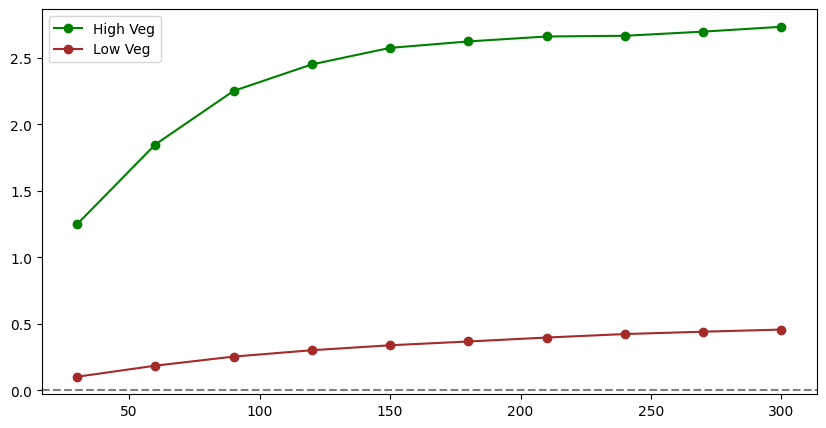

In [20]:
# Compare vegetation-rich vs. paved parks
plt.figure(figsize=(10,5))
for group, color in [('High Veg', 'green'), ('Low Veg', 'brown')]:
    subset = parks_gdf[parks_gdf['vegetation_prop'] > 0.5] if group == 'High Veg' else parks_gdf[parks_gdf['vegetation_prop'] <= 0.5]
    means = [subset[f'cooling_diff_{d}m'].mean() for d in range(30,301,30)]
    plt.plot(distances[1:], means, label=group, color=color, marker='o')

plt.axhline(0, color='gray', ls='--')
plt.legend()

Text(0, 0.5, 'Absolute LST (°C)')

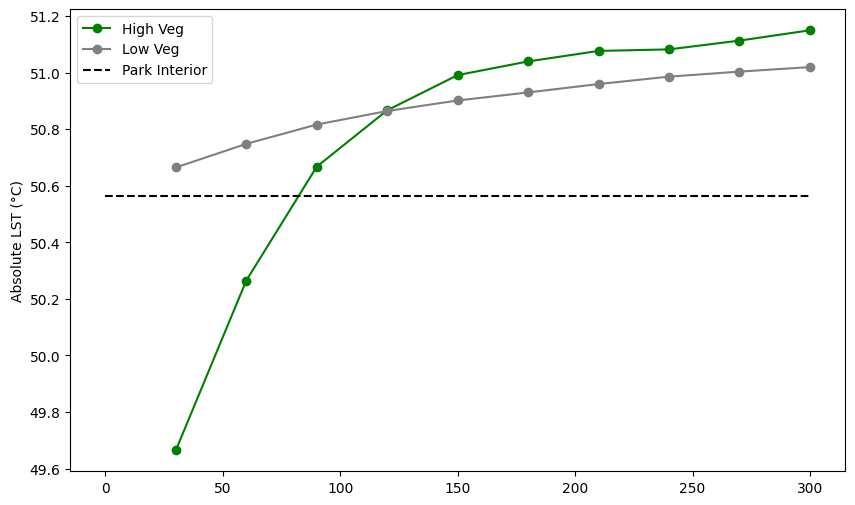

In [21]:
# Plot LST (not ΔT) to see absolute temperatures
plt.figure(figsize=(10,6))
for label, color in [('High Veg', 'green'), ('Low Veg', 'gray')]:
    subset = parks_gdf[parks_gdf['vegetation_prop'] > 0.5] if label == 'High Veg' else parks_gdf[parks_gdf['vegetation_prop'] <= 0.5]
    plt.plot(distances[1:], 
             [subset[f'lst_buffer_{d}m'].mean() for d in range(30,301,30)], 
             label=label, color=color, marker='o')

plt.plot([0, 300], [subset['lst_park'].mean()]*2, '--', color='black', label='Park Interior')
plt.legend()
plt.ylabel("Absolute LST (°C)")

Investigate parks (Identified from QGIS)

In [22]:
park_212 = parks_gdf[parks_gdf['park_id'] == 212].iloc[0]
print(f"""
Park 212 Profile:
- Name: {park_212['FEATURE_ANAME']}
- Area: {park_212['area_m2']:,.0f} m²
- NDVI: {park_212['ndvi_mean']:.2f}
- Vegetation Cover: {park_212['vegetation_prop']:.0%}
- Impervious: {park_212['impervious_prop']:.0%}
""")


Park 212 Profile:
- Name: None
- Area: 236,313 m²
- NDVI: 0.24
- Vegetation Cover: 65%
- Impervious: 11%



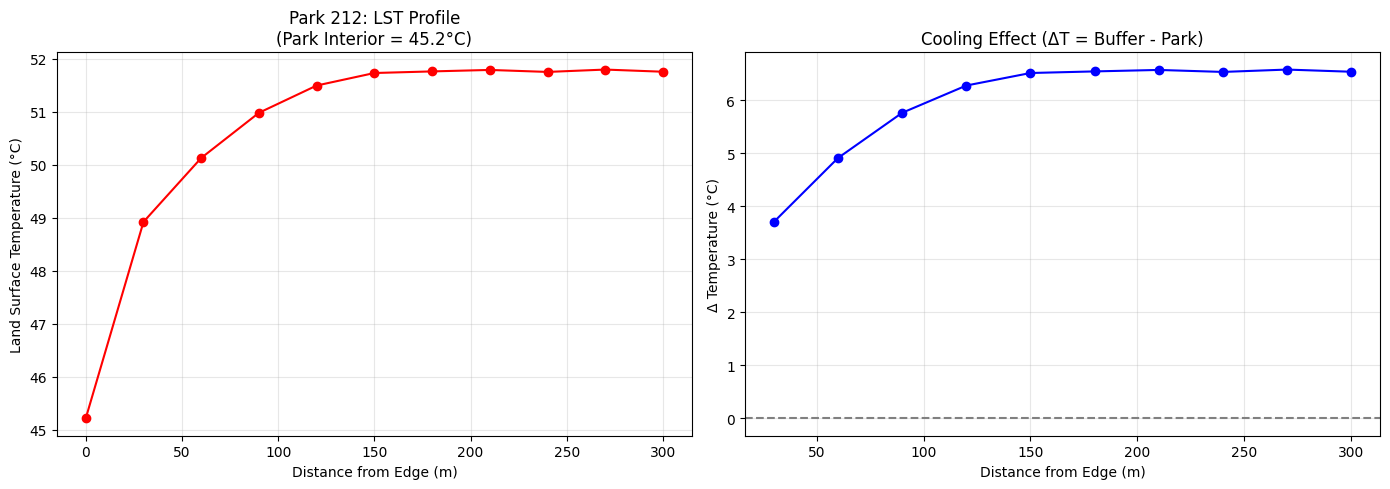

In [23]:
# Prepare data
distances = range(30, 301, 30)
park_lst = park_212['lst_park']
buffer_lst = [park_212[f'lst_buffer_{d}m'] for d in distances]
cooling = [park_212[f'cooling_diff_{d}m'] for d in distances]

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# Absolute temperatures
ax1.plot([0] + list(distances), [park_lst] + buffer_lst, 
         marker='o', color='red')
ax1.set_title(f"Park 212: LST Profile\n(Park Interior = {park_lst:.1f}°C)")
ax1.set_xlabel("Distance from Edge (m)")
ax1.set_ylabel("Land Surface Temperature (°C)")
ax1.grid(alpha=0.3)

# Cooling effect
ax2.plot(distances, cooling, marker='o', color='blue')
ax2.axhline(0, color='gray', ls='--')
ax2.set_title("Cooling Effect (ΔT = Buffer - Park)")
ax2.set_xlabel("Distance from Edge (m)")
ax2.set_ylabel("Δ Temperature (°C)")
ax2.grid(alpha=0.3)

plt.tight_layout()

Text(100, 53, 'Max ΔT: +6.6°C at 210m')

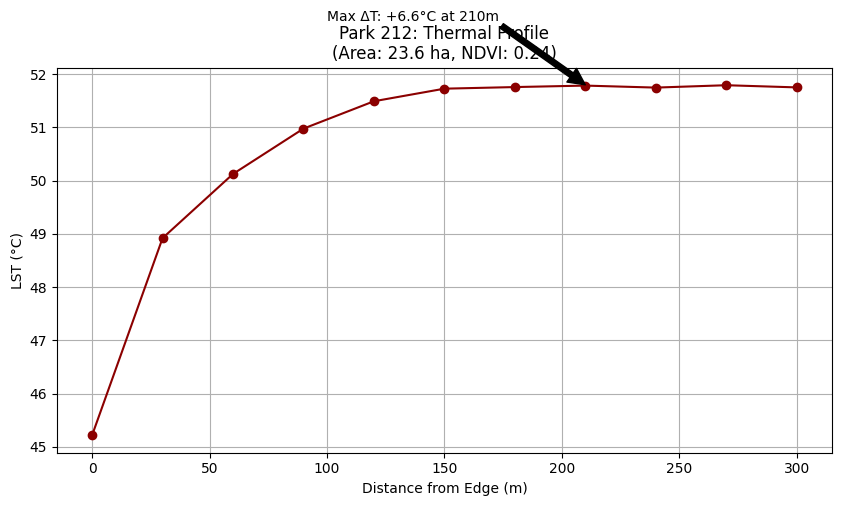

In [24]:
import matplotlib.pyplot as plt

# Temperature profile
distances = range(0, 301, 30)
temps = [park_212['lst_park']] + [park_212[f'lst_buffer_{d}m'] for d in distances[1:]]

plt.figure(figsize=(10,5))
plt.plot(distances, temps, marker='o', color='darkred')
plt.title(f"Park 212: Thermal Profile\n(Area: {park_212['area_m2']/10000:.1f} ha, NDVI: {park_212['ndvi_mean']:.2f})")
plt.xlabel("Distance from Edge (m)")
plt.ylabel("LST (°C)")
plt.grid()
plt.annotate(f"Max ΔT: +{park_212['cooling_diff_210m']:.1f}°C at 210m", 
             xy=(210, 51.8), xytext=(100, 53),
             arrowprops=dict(facecolor='black'))

In [25]:
# Compare to typical parks
median_park = parks_gdf[parks_gdf['vegetation_prop'] > 0.6]['lst_park'].median()
print(f"Median LST for vegetated parks: {median_park:.1f}°C vs Park 212: {park_212['lst_park']:.1f}°C")

Median LST for vegetated parks: 47.3°C vs Park 212: 45.2°C
